### Imports

In [2]:
import pandas as pd
import json
import numpy as np
import tensorflow
import os

import warnings
warnings.filterwarnings(action="ignore")

### Connect to drive and load data

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Concatenating all the datasets that we downloaded from -
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/O5A0ZV

In [4]:
dir_path = "drive/MyDrive/data_CNN_research"
df_cnn1 = pd.DataFrame(columns=["label", "subset", "image"])

for file in os.listdir(dir_path):

  if file.startswith("CNN_1"):
    df_cnn1 = pd.concat([df_cnn1, pd.read_csv(f"{dir_path}/{file}", index_col=0)])
df_cnn1 = pd.read_csv(f"{dir_path}/CNN_1.csv")

df_cnn2 = pd.DataFrame(columns=["label", "subset", "image"])

for file in os.listdir(dir_path):

  if file.startswith("CNN_2"):
    df_cnn2 = pd.concat([df_cnn2, pd.read_csv(f"{dir_path}/{file}", index_col=0)])
df_cnn2.to_csv("drive/MyDrive/data_CNN_research/CNN_2.csv")


In [13]:
lebels_mapping = {
    "BitTorrent": 0,
    "Cridex": 1,
    "WorldOfWarcraft": 0,
    "Weibo": 0,
    "Virut": 1,
    "Tinba": 1,
    "Skype": 0,
    "Shifu": 1,
    "SMB": 0,
    "Outlook": 0,
    "Nsis-ay": 1,
    "Neris": 1,
    "MySQL": 0,
    "Miuref": 1,
    "Htbot": 1,
    "Gmail": 0,
    "Geodo": 1,
    "Facetime": 0,
    "FTP": 0,
    "Zeus": 1
}

In [ ]:
df_cnn1.value_counts("label")

label
BitTorrent         30000
Cridex             30000
WorldOfWarcraft    30000
Weibo              30000
Virut              30000
Tinba              30000
Skype              30000
Shifu              30000
SMB                30000
Outlook            30000
Nsis-ay            30000
Neris              30000
MySQL              30000
Miuref             30000
Htbot              30000
Gmail              30000
Geodo              30000
Facetime           30000
FTP                30000
Zeus               30000
Name: count, dtype: int64

In [ ]:
df_cnn2.value_counts("label")

label
BitTorrent         30000
Cridex             30000
WorldOfWarcraft    30000
Weibo              30000
Virut              30000
Tinba              30000
Skype              30000
Shifu              30000
SMB                30000
Outlook            30000
Nsis-ay            30000
Neris              30000
MySQL              30000
Miuref             30000
Htbot              30000
Gmail              30000
Geodo              30000
Facetime           30000
FTP                30000
Zeus               30000
Name: count, dtype: int64

Both datasets are very well balanced label-wise which will ease the work for us.

## Loading the data and preprocessing it

In [5]:
def preprocess_data(df):
  """
  Reshaping each image to an array and normalizing it.
  """
  df.reset_index(inplace=True)

  for index, (key, row) in enumerate(df.iterrows()):

    if index%1000 == 0:
      print(index, end="\r")
    byte_string = bytes.fromhex(row.image[108:])
    image_array = np.frombuffer(byte_string, dtype=np.uint8)
    image_array = image_array.reshape(img_height, img_width, 3)
    image_array = image_array.astype('float32') / 255.0
    df.at[index, "image"] = image_array
  return df


In [ ]:
df_cnn1 = preprocess_data(df_cnn1[:int(len(df_cnn1)/2)])

In [ ]:
df_cnn2 = preprocess_data(df_cnn2[:int(len(df_cnn2)/4)])

In [ ]:
df_cnn1.label = df_cnn1.label.map(lebels_mapping)
df_cnn2.label = df_cnn2.label.map(lebels_mapping)

#### Split train and test - CNN 1

In [ ]:
X_train_full = df_cnn1[df_cnn1['subset'] == 0].image
y_train_full = df_cnn1[df_cnn1['subset'] == 0].label
X_test = df_cnn1[df_cnn1['subset'] == 1].image
y_test = df_cnn1[df_cnn1['subset'] == 1].label

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.15)

## The CNN - 1 model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
img_height = 21 # CNN 1 - else 42
img_width = 24
channels = 3

In [ ]:
model = models.Sequential([
  layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(img_height, img_width, channels)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 22, 32)        896       
                                                                 
 flatten (Flatten)           (None, 13376)             0         
                                                                 
 dense (Dense)               (None, 128)               1712256   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1713797 (6.54 MB)
Trainable params: 1713797 (6.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

Creating callback functions for the model training -
1. Early stopping to avoid overfitting
2. ReduceLROnPlateau to reduce the learning rate when reaching plateau

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

In [ ]:
X_train_arr= np.asarray(list(X_train)).reshape(-1, 21, 24, 3)
X_valid_arr= np.asarray(list(X_valid)).reshape(-1, 21, 24, 3)

In [ ]:
history = model.fit(X_train_arr, y_train, batch_size=32, validation_data=(X_valid_arr, y_valid),
                    epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
7268/7268 [==============================] - 38s 5ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 7.0018e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
7268/7268 [==============================] - 36s 5ms/step - loss: 5.5748e-04 - accuracy: 0.9999 - val_loss: 3.0705e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
7268/7268 [==============================] - 34s 5ms/step - loss: 1.5063e-04 - accuracy: 1.0000 - val_loss: 3.9499e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
7268/7268 [==============================] - 32s 4ms/step - loss: 1.4612e-04 - accuracy: 1.0000 - val_loss: 9.8492e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
7268/7268 [==============================] - 31s 4ms/step - loss: 3.3175e-04 - accuracy: 1.0000 - val_loss: 5.9198e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
7265/7268 [============================>.] - ETA: 0s - loss: 3.2323e-04 - accuracy: 0.9999
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000

Saving the model

In [26]:
import joblib

In [ ]:
joblib.dump(model, "model_cnn1_v2.pkl")

['model_cnn1_v2.pkl']

#### Evaluating the model

In [ ]:
y_pred = model.predict(np.asarray(list(X_test)).reshape(-1, 21, 24, 3))
y_pred = (y_pred > 0.5).astype(int)

825/825 [==============================] - 2s 3ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Averaged Precision:", precision)
print("Averaged Recall:", recall)
print("Averaged F1-score:", f1)

Accuracy: 1.0
Averaged Precision: 1.0
Averaged Reca\ll: 1.0
Averaged F1-score: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[14400,     0],
       [    0, 12000]])

Those results are even more than what was described in the research paper (where they described more then 99.5% accuracy), which can be explained that in the research they used much more data

## Split train and test - CNN 2

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
img_height = 42 # CNN 2 - else 21
img_width = 24
channels = 3

In [ ]:
X_train_full = df_cnn2[df_cnn2['subset'] == 0].image
y_train_full = df_cnn2[df_cnn2['subset'] == 0].label
X_test = df_cnn2[df_cnn2['subset'] == 1].image
y_test = df_cnn2[df_cnn2['subset'] == 1].label

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.15)

### Train CNN - 2

In [ ]:
model = models.Sequential([
  layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(img_height, img_width, channels)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
X_train_arr= np.asarray(list(X_train)).reshape(-1, 42, 24, 3)
X_valid_arr= np.asarray(list(X_valid)).reshape(-1, 42, 24, 3)

In [ ]:
history = model.fit(X_train_arr, y_train, batch_size=32, validation_data=(X_valid_arr, y_valid),
                    epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
3618/3618 [==============================] - 23s 5ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 2.5616e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/100
3618/3618 [==============================] - 17s 5ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0076 - val_accuracy: 0.9997 - lr: 0.0010
Epoch 3/100
3618/3618 [==============================] - 19s 5ms/step - loss: 4.8088e-04 - accuracy: 0.9999 - val_loss: 4.9153e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/100
3618/3618 [==============================] - 17s 5ms/step - loss: 2.2478e-05 - accuracy: 1.0000 - val_loss: 3.0096e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 5/100
3618/3618 [==============================] - 17s 5ms/step - loss: 4.8616e-07 - accuracy: 1.0000 - val_loss: 1.2924e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
3618/3618 [==============================] - 22s 6ms/step - loss: 9.3946e-08 - accuracy: 1.0000 - val_loss: 1.2861e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10

In [ ]:
joblib.dump(model, "model_cnn2_v1.pkl")

['model_cnn2_v1.pkl']

### Evaluating model - CNN 2

In [ ]:
y_pred = model.predict(np.asarray(list(X_test)).reshape(-1, 42, 24, 3))
y_pred = (y_pred > 0.5).astype(int)

432/432 [==============================] - 3s 6ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Averaged Precision:", precision)
print("Averaged Recall:", recall)
print("Averaged F1-score:", f1)

Accuracy: 1.0
Averaged Precision: 1.0
Averaged Recall: 1.0
Averaged F1-score: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[7800,    0],
       [   0, 6000]])

Both models have extraordinary results, but the second one converged in less than half of the time the first one converged.

## DNN

In [ ]:
model = models.Sequential([
    layers.Flatten(input_shape=(21, 24, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_arr, y_train, batch_size=32, validation_data=(X_valid_arr, y_valid),
                    epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
7268/7268 [==============================] - 52s 7ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 2.6389e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/100
7268/7268 [==============================] - 48s 7ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 2.0045e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
7268/7268 [==============================] - 48s 7ms/step - loss: 5.4690e-04 - accuracy: 0.9999 - val_loss: 3.2639e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/100
7268/7268 [==============================] - 49s 7ms/step - loss: 6.4668e-04 - accuracy: 1.0000 - val_loss: 2.8721e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
7268/7268 [==============================] - 49s 7ms/step - loss: 2.3732e-04 - accuracy: 1.0000 - val_loss: 5.3640e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
7268/7268 [==============================] - 47s 6ms/step - loss: 5.0324e-04 - accuracy: 1.0000 - val_loss: 5.8327e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 

In [ ]:
joblib.dump(model, "model_dnn1_v1.pkl")

['model_dnn1_v1.pkl']

Looking at the training process we can see that avoiding CNN layers give us great results as well.

## Zero day attack
Let's train the model on all the data except one of the attacks and see how it performs against a new malware or new methods

In [ ]:
df_cnn1.label.unique()

array(['Facetime', 'FTP', 'Outlook', 'Zeus', 'Tinba', 'Htbot', 'Geodo',
       'Shifu', 'Neris', 'BitTorrent', 'Weibo', 'SMB', 'Skype', 'Virut',
       'MySQL', 'Miuref', 'WorldOfWarcraft', 'Nsis-ay', 'Cridex', 'Gmail'],
      dtype=object)

We will exclude Shifu from this list (a trojan malware)

In [6]:
df_cnn1.reset_index(inplace=True)

In [7]:
shifu_images = df_cnn1.iloc[df_cnn1[df_cnn1.label == "Shifu"].index].copy()

In [8]:
df_cnn1.drop(df_cnn1[df_cnn1.label == "Shifu"].index, inplace=True)

In [14]:
img_height = 21
img_width = 24
channels = 3

df_cnn1 = preprocess_data(df_cnn1[:int(len(df_cnn1)/2)])
shifu_images = preprocess_data(shifu_images)
df_cnn1.label = df_cnn1.label.map(lebels_mapping)
shifu_images.label = shifu_images.label.map(lebels_mapping)

In [23]:
from tensorflow.keras import layers, models

In [24]:
model = models.Sequential([
  layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(img_height, img_width, channels)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train_full = df_cnn1[df_cnn1['subset'] == 0].image
y_train_full = df_cnn1[df_cnn1['subset'] == 0].label
X_test = df_cnn1[df_cnn1['subset'] == 1].image
y_test = df_cnn1[df_cnn1['subset'] == 1].label

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.15)

In [18]:
X_train_arr= np.asarray(list(X_train)).reshape(-1, 21, 24, 3)
X_valid_arr= np.asarray(list(X_valid)).reshape(-1, 21, 24, 3)

In [25]:
history = model.fit(X_train_arr, y_train, batch_size=32, validation_data=(X_valid_arr, y_valid),
                    epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
6870/6870 [==============================] - 37s 5ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 4.3829e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/100
6870/6870 [==============================] - 31s 5ms/step - loss: 3.0035e-04 - accuracy: 0.9999 - val_loss: 5.2906e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
6870/6870 [==============================] - 31s 5ms/step - loss: 6.0458e-04 - accuracy: 0.9999 - val_loss: 4.5774e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
6870/6870 [==============================] - 32s 5ms/step - loss: 3.8439e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 5/100
6870/6870 [==============================] - 31s 4ms/step - loss: 8.2707e-04 - accuracy: 1.0000 - val_loss: 4.3236e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
6868/6870 [============================>.] - ETA: 0s - loss: 4.7124e-06 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000100000004749

In [34]:
joblib.dump(model, "/content/drive/My Drive/Colab Notebooks/model_cnn1_zeroday.pkl")

['/content/drive/My Drive/Colab Notebooks/model_cnn1_zeroday.pkl']

### Evaluating model

No zero days eval

In [36]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [39]:
def plot_train_proc(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curve for CNN')
  plt.legend()
  plt.grid(True)
  plt.show()

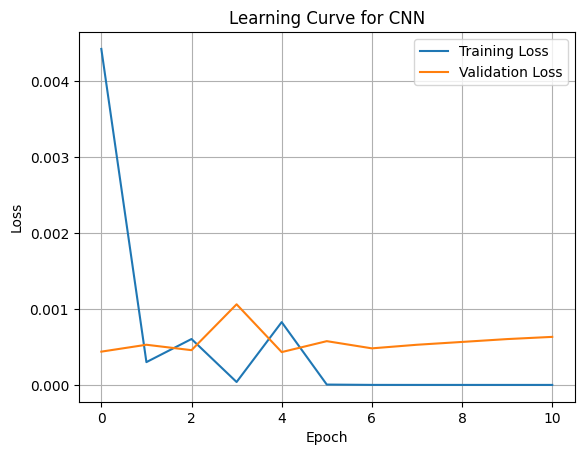

In [40]:
plot_train_proc(history)

There is a bit overfitting at the end

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [43]:
y_pred = model.predict(np.asarray(list(X_test)).reshape(-1, 21, 24, 3))
y_pred = (y_pred > 0.5).astype(int)

825/825 [==============================] - 3s 4ms/step


In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Averaged Precision:", precision)
print("Averaged Recall:", recall)
print("Averaged F1-score:", f1)

Accuracy: 1.0
Averaged Precision: 1.0
Averaged Recall: 1.0
Averaged F1-score: 1.0


In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[14400,     0],
       [    0, 12000]])

Zero day eval

In [52]:
y_pred_zero_day = model.predict(np.asarray(list(shifu_images.image)).reshape(-1, 21, 24, 3))
y_pred_zero_day = (y_pred_zero_day > 0.5).astype(int)

938/938 [==============================] - 2s 2ms/step


In [55]:
conf_mx = confusion_matrix(shifu_images.label, y_pred_zero_day)
conf_mx

array([[30000]])

In [59]:
accuracy = accuracy_score(shifu_images.label, y_pred_zero_day)
precision = precision_score(shifu_images.label, y_pred_zero_day, average='macro')
recall = recall_score(shifu_images.label, y_pred_zero_day, average='macro')
f1 = f1_score(shifu_images.label, y_pred_zero_day, average='macro')

print("Accuracy:", accuracy)
print("Averaged Precision:", precision)
print("Averaged Recall:", recall)
print("Averaged F1-score:", f1)

Accuracy: 1.0
Averaged Precision: 1.0
Averaged Recall: 1.0
Averaged F1-score: 1.0


The model is able to find even zero days attack that it didn't see before